

># **`Arya Chakraborty - 22MSD7020`**
> **`Lab Assignment -4 (Gender Classification)`**:



># **`Classifying Facial Images as either belonging to the Male or the Female class`**:👨🚺

>- **Importing Libraries** 🎈

In [1]:
import numpy as np
import zipfile
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch

- **For Parallel Processing**

In [2]:
from concurrent.futures import ThreadPoolExecutor

- **Importing Libraries for building the Models**

In [4]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D,AveragePooling2D, Activation

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.activations import relu, sigmoid, tanh

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> **Train DataSet**

In [6]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BIC_extraction_folder/train.csv")

train_data.head(20)

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1
5,7508.jpg,1
6,7288.jpg,1
7,9602.jpg,1
8,9028.jpg,0
9,12791.jpg,0


- Changing the class to catagorical class

In [7]:
train_data['class'] = to_categorical(train_data['class'])

- Test DataSet

In [8]:
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
test_data.head()

,image_names
0,5603.jpg
1,1286.jpg
2,9815.jpg
3,8865.jpg
4,9306.jpg


In [14]:
print(len(test_data))

5227


In [9]:
train_csv_file_path = "/content/drive/MyDrive/Colab Notebooks/BIC_extraction_folder/train.csv"
images_path = "/content/drive/MyDrive/Colab Notebooks/BIC_extraction_folder/images/"
image_filename_column = 'image_names'

> ThreadPoolExecutor

ThreadPoolExecutor and parallel processing reduce runtime by concurrently executing the load_image function for multiple image files using multiple threads. This utilizes available CPU cores, efficiently utilizing resources and decreasing the overall time required to load all images compared to a sequential execution.

In [16]:
train_images =[]

def load_image(img_name):
    img = plt.imread(os.path.join(images_path, img_name))
    return img

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(load_image, train_data.image_names), total=len(train_data.image_names)))

train_images = results

100%|██████████| 12196/12196 [16:53<00:00, 12.03it/s]


<div style="background-color: black; padding: 10px;">
  <p><strong>Gender Detection Model:</strong> Loaded a pre-trained model by <a href="https://huggingface.co/rizvandwiki/gender-classification-2">rizvandwiki</a> for gender classification.</p>
</div>


In [12]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("rizvandwiki/gender-classification-2")
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification-2")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


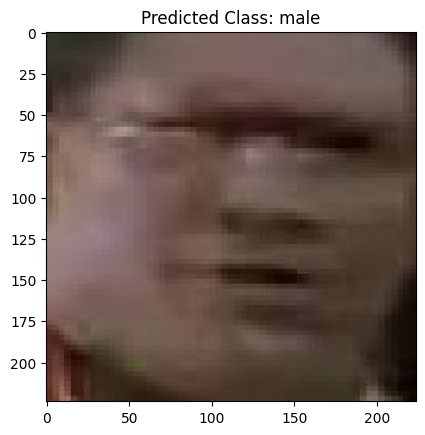

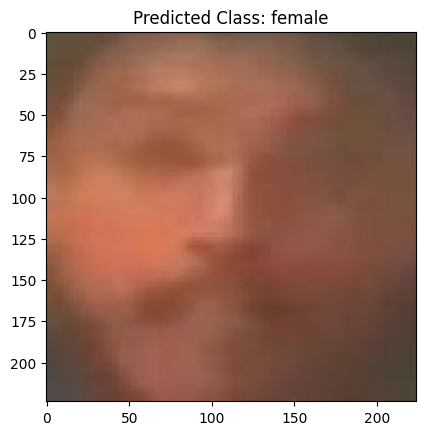

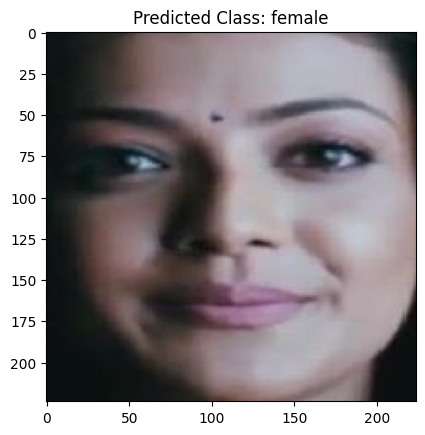

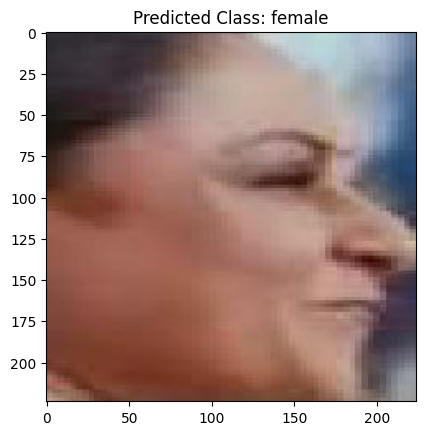

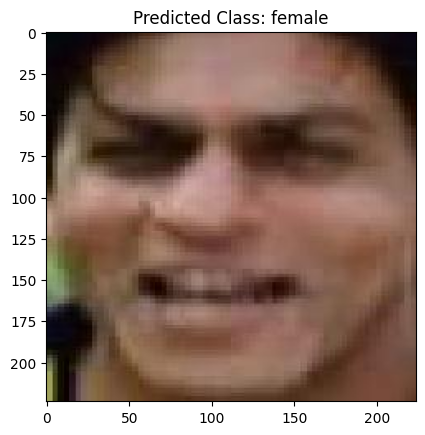

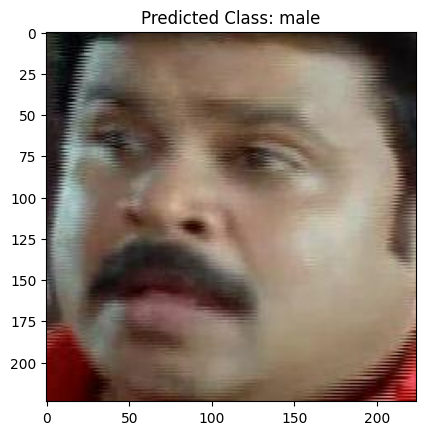

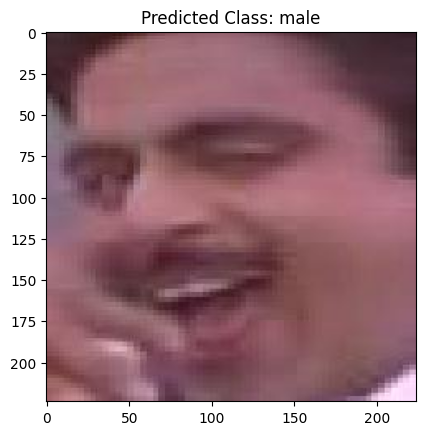

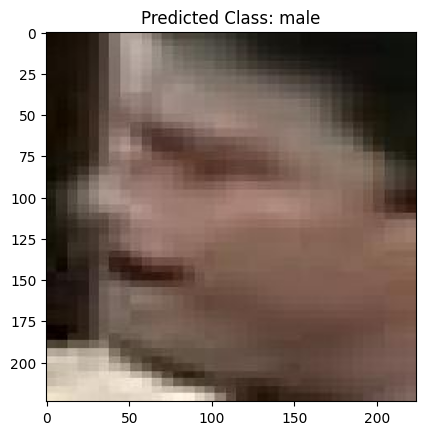

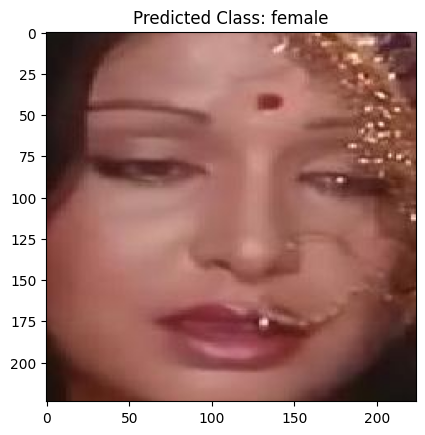

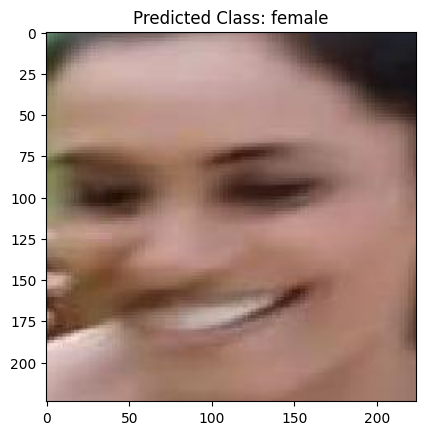

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

sample_image_names = train_data['image_names'][:10]

for image_name in range(10):

    img_path = f'{images_path}/{sample_image_names[image_name]}'
    img = image.load_img(img_path, target_size=(224, 224))

    inputs = extractor(images = train_images[image_name], return_tensors="pt" )
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        label = model.config.id2label[predicted_label]


    plt.imshow(img)
    plt.title(f'Predicted Class: {label}')
    plt.show()

## Using CNN Model

In [10]:
image_size = (224, 224)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=images_path,
    x_col='image_names',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='training'
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=images_path,
    x_col='image_names',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    subset='validation'
)

- **1st CNN model**

- creating the model architecture

In [36]:
early_stopping = EarlyStopping(monitor = 'accuracy' , patience = 2  ,restore_best_weights = True )

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model_hist = model.fit(train_generator,
                        validation_data=valid_generator,
                        verbose=2,epochs=5,batch_size=32,
                        callbacks=[early_stopping])

Epoch 1/5
153/153 - 55s - loss: 0.5669 - accuracy: 0.7025 - val_loss: 0.4800 - val_accuracy: 0.7823 - 55s/epoch - 360ms/step
Epoch 2/5
153/153 - 38s - loss: 0.4340 - accuracy: 0.8079 - val_loss: 0.4224 - val_accuracy: 0.8093 - 38s/epoch - 246ms/step
Epoch 3/5
153/153 - 41s - loss: 0.4019 - accuracy: 0.8194 - val_loss: 0.4143 - val_accuracy: 0.8032 - 41s/epoch - 268ms/step
Epoch 4/5
153/153 - 38s - loss: 0.3611 - accuracy: 0.8426 - val_loss: 0.3642 - val_accuracy: 0.8389 - 38s/epoch - 247ms/step
Epoch 5/5
153/153 - 41s - loss: 0.3217 - accuracy: 0.8610 - val_loss: 0.3379 - val_accuracy: 0.8573 - 41s/epoch - 271ms/step


**Model Accuracy ~**
 **Train = 86.1%**
 **Test = 85.7%**

### Saving the model

In [37]:
model.save('1st_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Using this Model for predicting the class of 10 images from Test Data

1/1 [==============================] - 0s 402ms/step


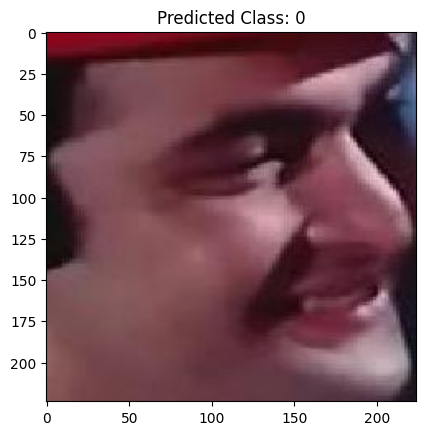

1/1 [==============================] - 0s 30ms/step


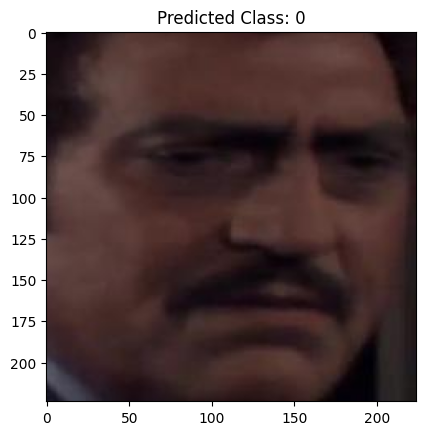

1/1 [==============================] - 0s 37ms/step


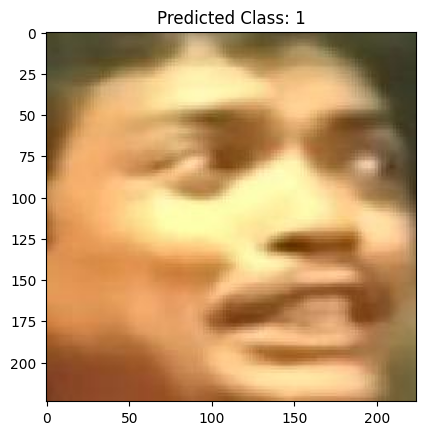

1/1 [==============================] - 0s 27ms/step


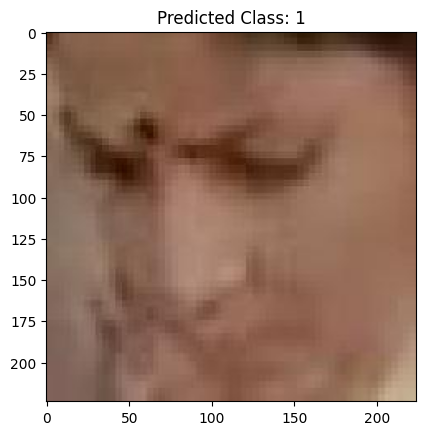

1/1 [==============================] - 0s 31ms/step


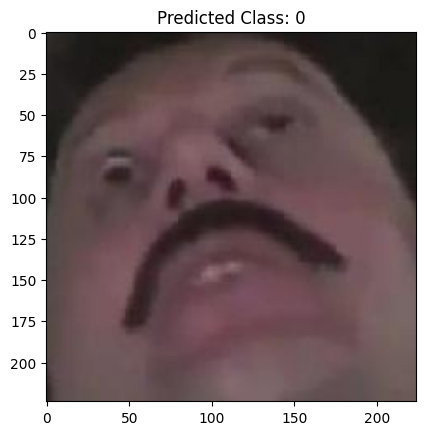

1/1 [==============================] - 0s 20ms/step


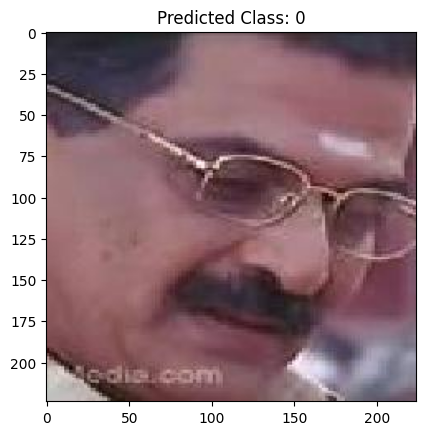

1/1 [==============================] - 0s 18ms/step


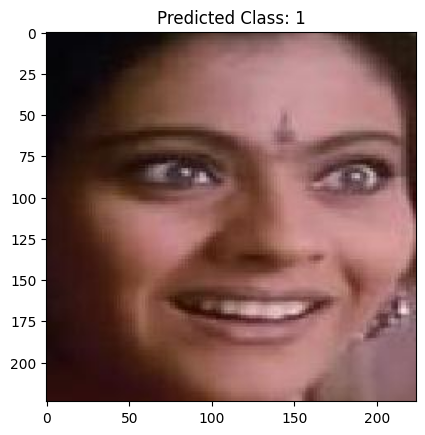

1/1 [==============================] - 0s 20ms/step


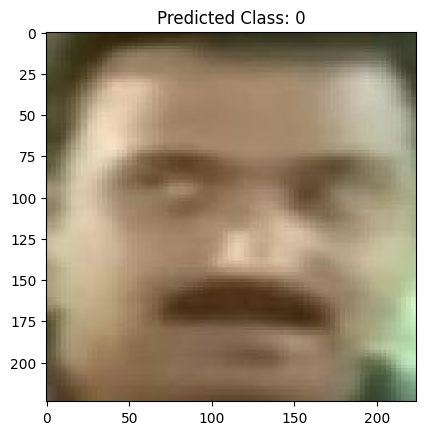

1/1 [==============================] - 0s 25ms/step


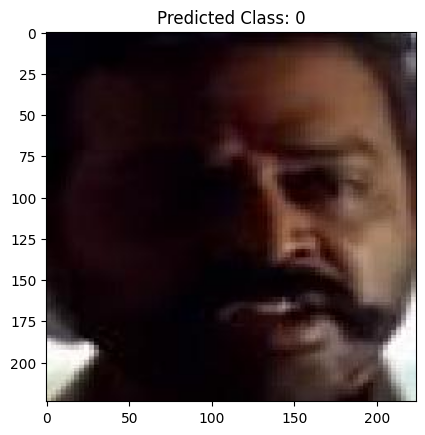

1/1 [==============================] - 0s 19ms/step


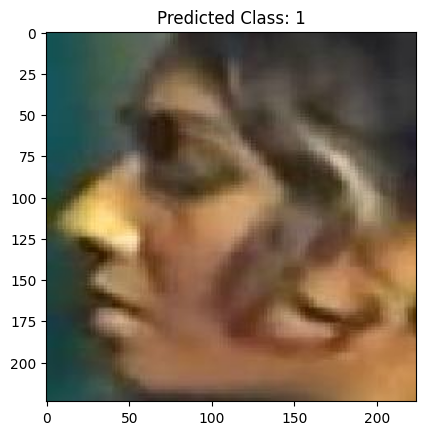

In [38]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

sample_image_names = test_data['image_names'][:10]

for image_name in sample_image_names:

    img_path = f'{images_path}/{image_name}'
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255

    prediction = model.predict(x)
    predicted_class = (prediction >= 0.5).astype(int)[0][0]  # Apply threshold and get class

    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()


- **Changing Some Parameters**

In [45]:
early_stopping = EarlyStopping(monitor = 'accuracy' , patience = 2  ,restore_best_weights = True )

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model_hist = model.fit(train_generator,
                        validation_data=valid_generator,
                        verbose=2,epochs=10,batch_size=32,
                        callbacks=[early_stopping])

Epoch 1/10
153/153 - 42s - loss: 0.6512 - accuracy: 0.6016 - val_loss: 0.5615 - val_accuracy: 0.7302 - 42s/epoch - 277ms/step
Epoch 2/10
153/153 - 39s - loss: 0.4959 - accuracy: 0.7721 - val_loss: 0.4535 - val_accuracy: 0.7921 - 39s/epoch - 253ms/step
Epoch 3/10
153/153 - 44s - loss: 0.4186 - accuracy: 0.8177 - val_loss: 0.4063 - val_accuracy: 0.8208 - 44s/epoch - 290ms/step
Epoch 4/10
153/153 - 40s - loss: 0.3754 - accuracy: 0.8308 - val_loss: 0.3615 - val_accuracy: 0.8364 - 40s/epoch - 261ms/step
Epoch 5/10
153/153 - 41s - loss: 0.3254 - accuracy: 0.8581 - val_loss: 0.3593 - val_accuracy: 0.8421 - 41s/epoch - 265ms/step
Epoch 6/10
153/153 - 38s - loss: 0.2766 - accuracy: 0.8805 - val_loss: 0.3497 - val_accuracy: 0.8544 - 38s/epoch - 245ms/step
Epoch 7/10
153/153 - 39s - loss: 0.2364 - accuracy: 0.9001 - val_loss: 0.2894 - val_accuracy: 0.8786 - 39s/epoch - 257ms/step
Epoch 8/10
153/153 - 39s - loss: 0.1990 - accuracy: 0.9157 - val_loss: 0.2935 - val_accuracy: 0.8774 - 39s/epoch - 253

**Model Accuracy ~**
 **Train = 94.2%**
 **Test = 89.3%**

-**Saving the Model**

In [58]:
model.save('2nd_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


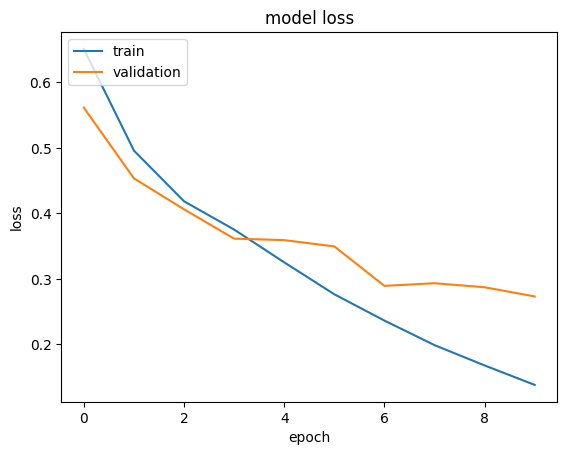

In [48]:
plt.plot(Model_hist.history['loss'])
plt.plot(Model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


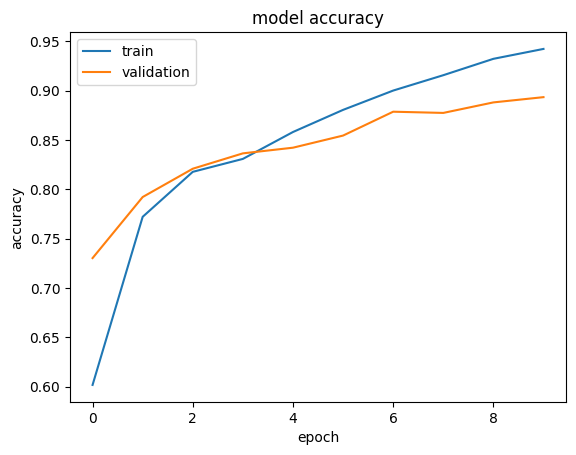

In [49]:
plt.plot(Model_hist.history['accuracy'])
plt.plot(Model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Hyper Parameter Tuning This Model.

- Using AveragePooling2D

In [ ]:
early_stopping = EarlyStopping(monitor = 'accuracy' , patience = 2  ,restore_best_weights = True )

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(AveragePooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model_hist = model.fit(train_generator,
                        validation_data=valid_generator,
                        verbose=2,epochs=25,batch_size=32,
                        callbacks=[early_stopping])

**Model Accuracy ~**
 **Train = 96.2%**
 **Test = 94.1%**

> `**HyperParameter Tuning using Mixed Precision Training**`

Mixed Precision Training is a strategy in deep learning that leverages both lower (float16) and higher (float32) numerical precisions during neural network training. It optimizes memory usage and computational efficiency on GPUs. Specifically, float16 is applied to non-critical parts of the network, such as activations and gradients, reducing memory requirements and accelerating computation. Meanwhile, float32 precision is retained for critical components to ensure numerical stability. This approach exploits the benefits of float16's speed and memory efficiency while mitigating potential numerical issues, resulting in faster training times and the ability to train larger and more complex models on GPUs with limited memory.

In [ ]:
def create_model_mixed_precision(hidden_layers=1, neurons=128, optimizer='adam', loss='binary_crossentropy', activation='relu'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    for _ in range(hidden_layers):
        model.add(Conv2D(neurons, (3, 3)))
        model.add(Activation(activation))  
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model




param_grid = {
    'hidden_layers': [1, 2, 3],
    'neurons': [128, 256, 512],
    'optimizer': [Adam(), RMSprop()],
    'loss': [BinaryCrossentropy(), CategoricalCrossentropy()],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'epochs': [5, 10, 15],
    'batch_size': [16, 32],
    'dropout_rate': [0.2, 0.4],
    'use_batch_normalization': [True, False]
}

best_score = 0
best_params = None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []

    for hidden_layers in param_grid['hidden_layers']:
        for neurons in param_grid['neurons']:
            for optimizer in param_grid['optimizer']:
                for loss in param_grid['loss']:
                    for activation in param_grid['activation']:
                        for epochs in param_grid['epochs']:
                            for batch_size in param_grid['batch_size']:
                                for dropout_rate in param_grid['dropout_rate']:
                                    for use_batch_norm in param_grid['use_batch_normalization']:
                                     
                                        model = create_model_mixed_precision()

                                        
                                        future = executor.submit(model.fit, train_generator,
                                                                  validation_data=valid_generator,
                                                                  verbose=0, epochs=epochs, batch_size=batch_size,
                                                                  callbacks=[early_stopping])
                                        futures.append(future)

    
    for future in tqdm(futures, total=len(futures), unit='model'):
        future.result() 

       
        score = model.evaluate(valid_generator, verbose=0)[1]

      
        if score > best_score:
            best_score = score
            best_params = {
                'hidden_layers': hidden_layers,
                'neurons': neurons,
                'optimizer': optimizer,
                'loss': loss,
                'activation': activation,
                'epochs': epochs,
                'batch_size': batch_size,
                'dropout_rate': dropout_rate,
                'use_batch_normalization': use_batch_norm
            }

print("Best Score:", best_score)
print("Best Parameters:", best_params)
